In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ROOT = "C:/Users/Emile/Documents/Polytechnique/4A/ParisSaclay/Stage/spinal_cross_species_V1/"

In [3]:
# Load integrated cross-species data
integrated = sc.read_h5ad(ROOT + "data/co_integrated_data/cross_species_all_sets_common_genes.h5ad")

In [4]:
integrated.obs['training_labels'].value_counts()

training_labels
-1.0    80425
 0.0     3265
 1.0     1820
Name: count, dtype: int64

In [5]:
mouse = integrated[integrated.obs['species'] == 'mouse']
human = integrated[integrated.obs['species'] == 'human']

In [6]:
mouse.obs['orig.ident'] = mouse.obs['orig.ident'].apply(lambda x: 'KNAF13' if x == 'KNAF14' else x)

C:\Users\Emile\AppData\Local\Temp\ipykernel_27232\3826581645.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mouse.obs['orig.ident'] = mouse.obs['orig.ident'].apply(lambda x: 'KNAF13' if x == 'KNAF14' else x)


In [7]:
mouse.obs['orig.ident'].value_counts()

orig.ident
GSM7474503    6784
KNAF13        6039
GSE7474501    4260
KNAF3         3265
KATHE         2331
MATSON        2305
KNAF4         1820
BOUV5         1417
Name: count, dtype: int64

In [8]:
integrated = sc.concat([mouse, human])

In [9]:
del mouse, human

In [10]:
# Rename the layers with the patient name
integrated.obs['orig.ident'] = integrated.obs['orig.ident'].apply(lambda x : 'KNAF10_Humain-P12_NeuN_221124' if x == 'KNAF10' else 'KNAF11_Humain-P13_NeuN_221124' if x == 'KNAF11' else 'KNAF12_Humain-P11_NeuN_180325' if x == 'KNAF12' else 'KNAF16_Humain-P10_NeuN_130525' if x == 'KNAF16' else 'KNAF17_Humain-P8_NeuN_130525' if x == 'KNAF17' else x)

In [11]:
integrated.obs['orig.ident'].groupby(integrated.obs['species']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_27232\2359467213.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  integrated.obs['orig.ident'].groupby(integrated.obs['species']).value_counts()


species  orig.ident                   
human    KNAF8                            9295
         KNAF12_Humain-P11_NeuN_180325    8688
         KNAF17_Humain-P8_NeuN_130525     6176
         KNAF15                           5951
         KNAF14                           5706
         KNAF9                            5153
         KNAF16_Humain-P10_NeuN_130525    4822
         ZHANG                            3663
         YADAV                            3555
         KNAF11_Humain-P13_NeuN_221124    2598
         KNAF10_Humain-P12_NeuN_221124    1682
         BOUV5                               0
         GSE7474501                          0
         GSM7474503                          0
         KATHE                               0
         KNAF3                               0
         KNAF4                               0
         KNAF13                              0
         MATSON                              0
mouse    GSM7474503                       6784
         KNAF13      

In [12]:
integrated.obs['training_labels'].value_counts()

training_labels
-1.0    80425
 0.0     3265
 1.0     1820
Name: count, dtype: int64

In [14]:
sc.write(ROOT + "data/co_integrated_data/cross_species_all_sets_common_genes.h5ad", integrated)

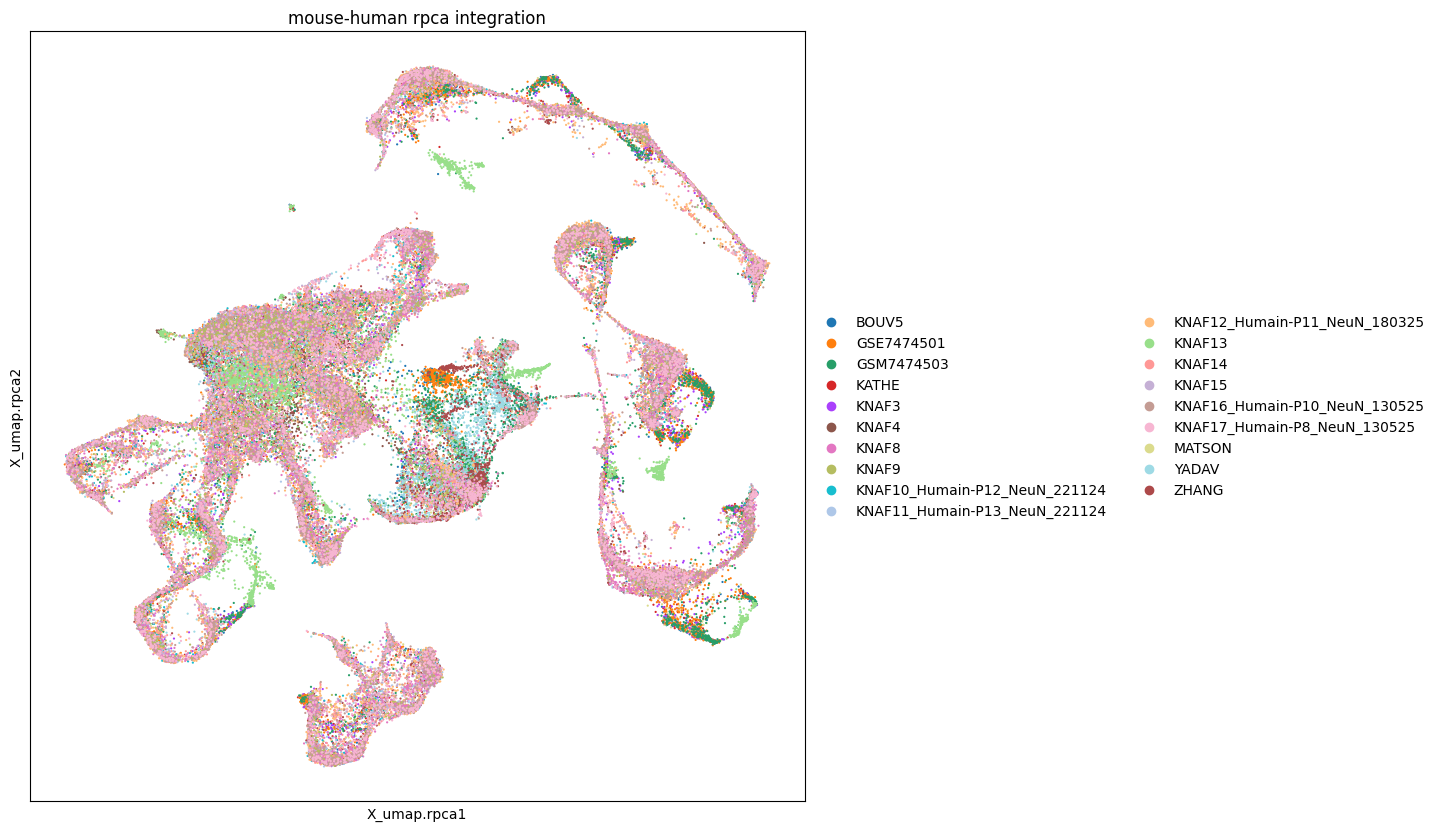

In [15]:
# Plot the UMAP of the integrated dataset
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(integrated, basis='X_umap.rpca', color='orig.ident', title='mouse-human rpca integration', ax =ax, size = 10)

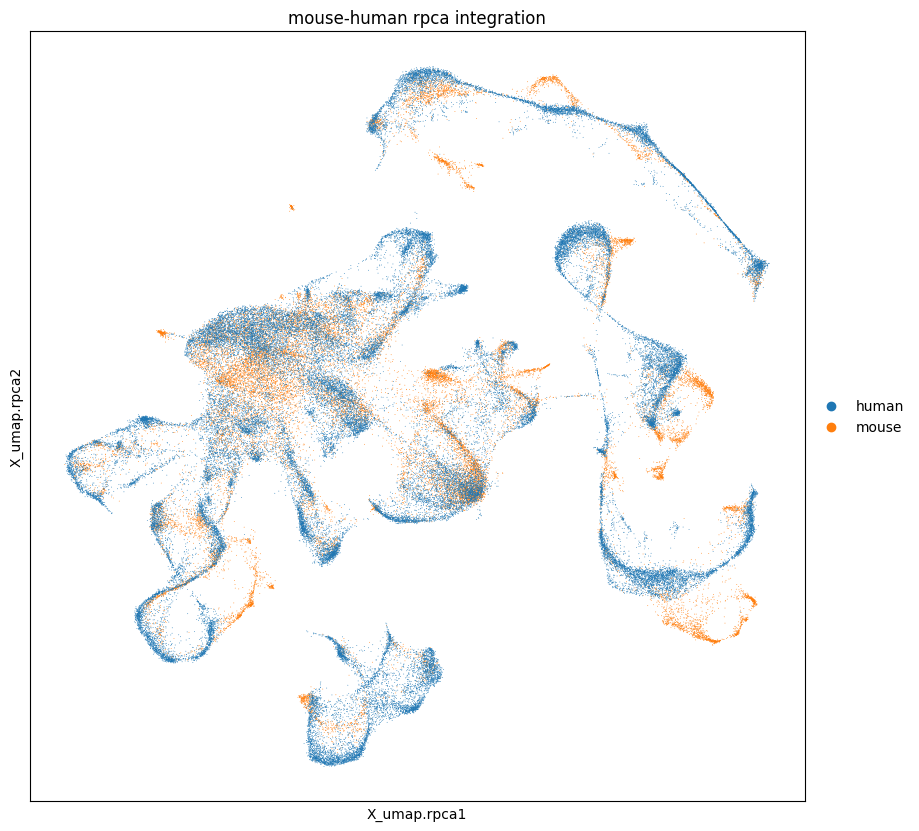

In [16]:
# Plot the UMAP of the integrated dataset
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(integrated, basis='X_umap.rpca', color='species', title='mouse-human rpca integration', ax =ax)

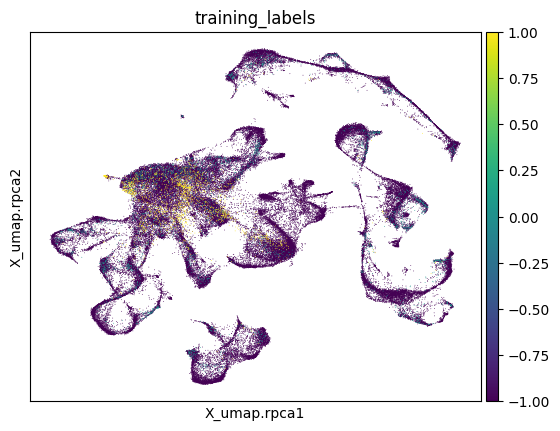

In [17]:
# Plot the UMAP of the integrated dataset
sc.pl.embedding(integrated, basis = 'X_umap.rpca', color='training_labels')

In [18]:
integrated.obs['training_labels'].groupby(integrated.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_12040\1844855084.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  integrated.obs['training_labels'].groupby(integrated.obs['orig.ident']).value_counts()


orig.ident                     training_labels
BOUV5                          -1.0               1417
                                0.0                  0
                                1.0                  0
GSE7474501                     -1.0               4260
                                0.0                  0
                                1.0                  0
GSM7474503                     -1.0               6784
                                0.0                  0
                                1.0                  0
KATHE                          -1.0               2331
                                0.0                  0
                                1.0                  0
KNAF3                           0.0               3265
                               -1.0                  0
                                1.0                  0
KNAF4                           1.0               1820
                               -1.0                  0
                  

In [19]:
# Create annotation column in .obs
integrated.obs['annotation'] = integrated.obs['training_labels'].apply(lambda x: 'V1_CITEseq+' if x == 1 else 'CITEseq-' if x == 0 else 'Unnassigned')
integrated.obs['annotation'] = integrated.obs['annotation'].astype('category')
integrated.obs['training_labels'].value_counts()

training_labels
-1.0    80425
 0.0     3265
 1.0     1820
Name: count, dtype: int64

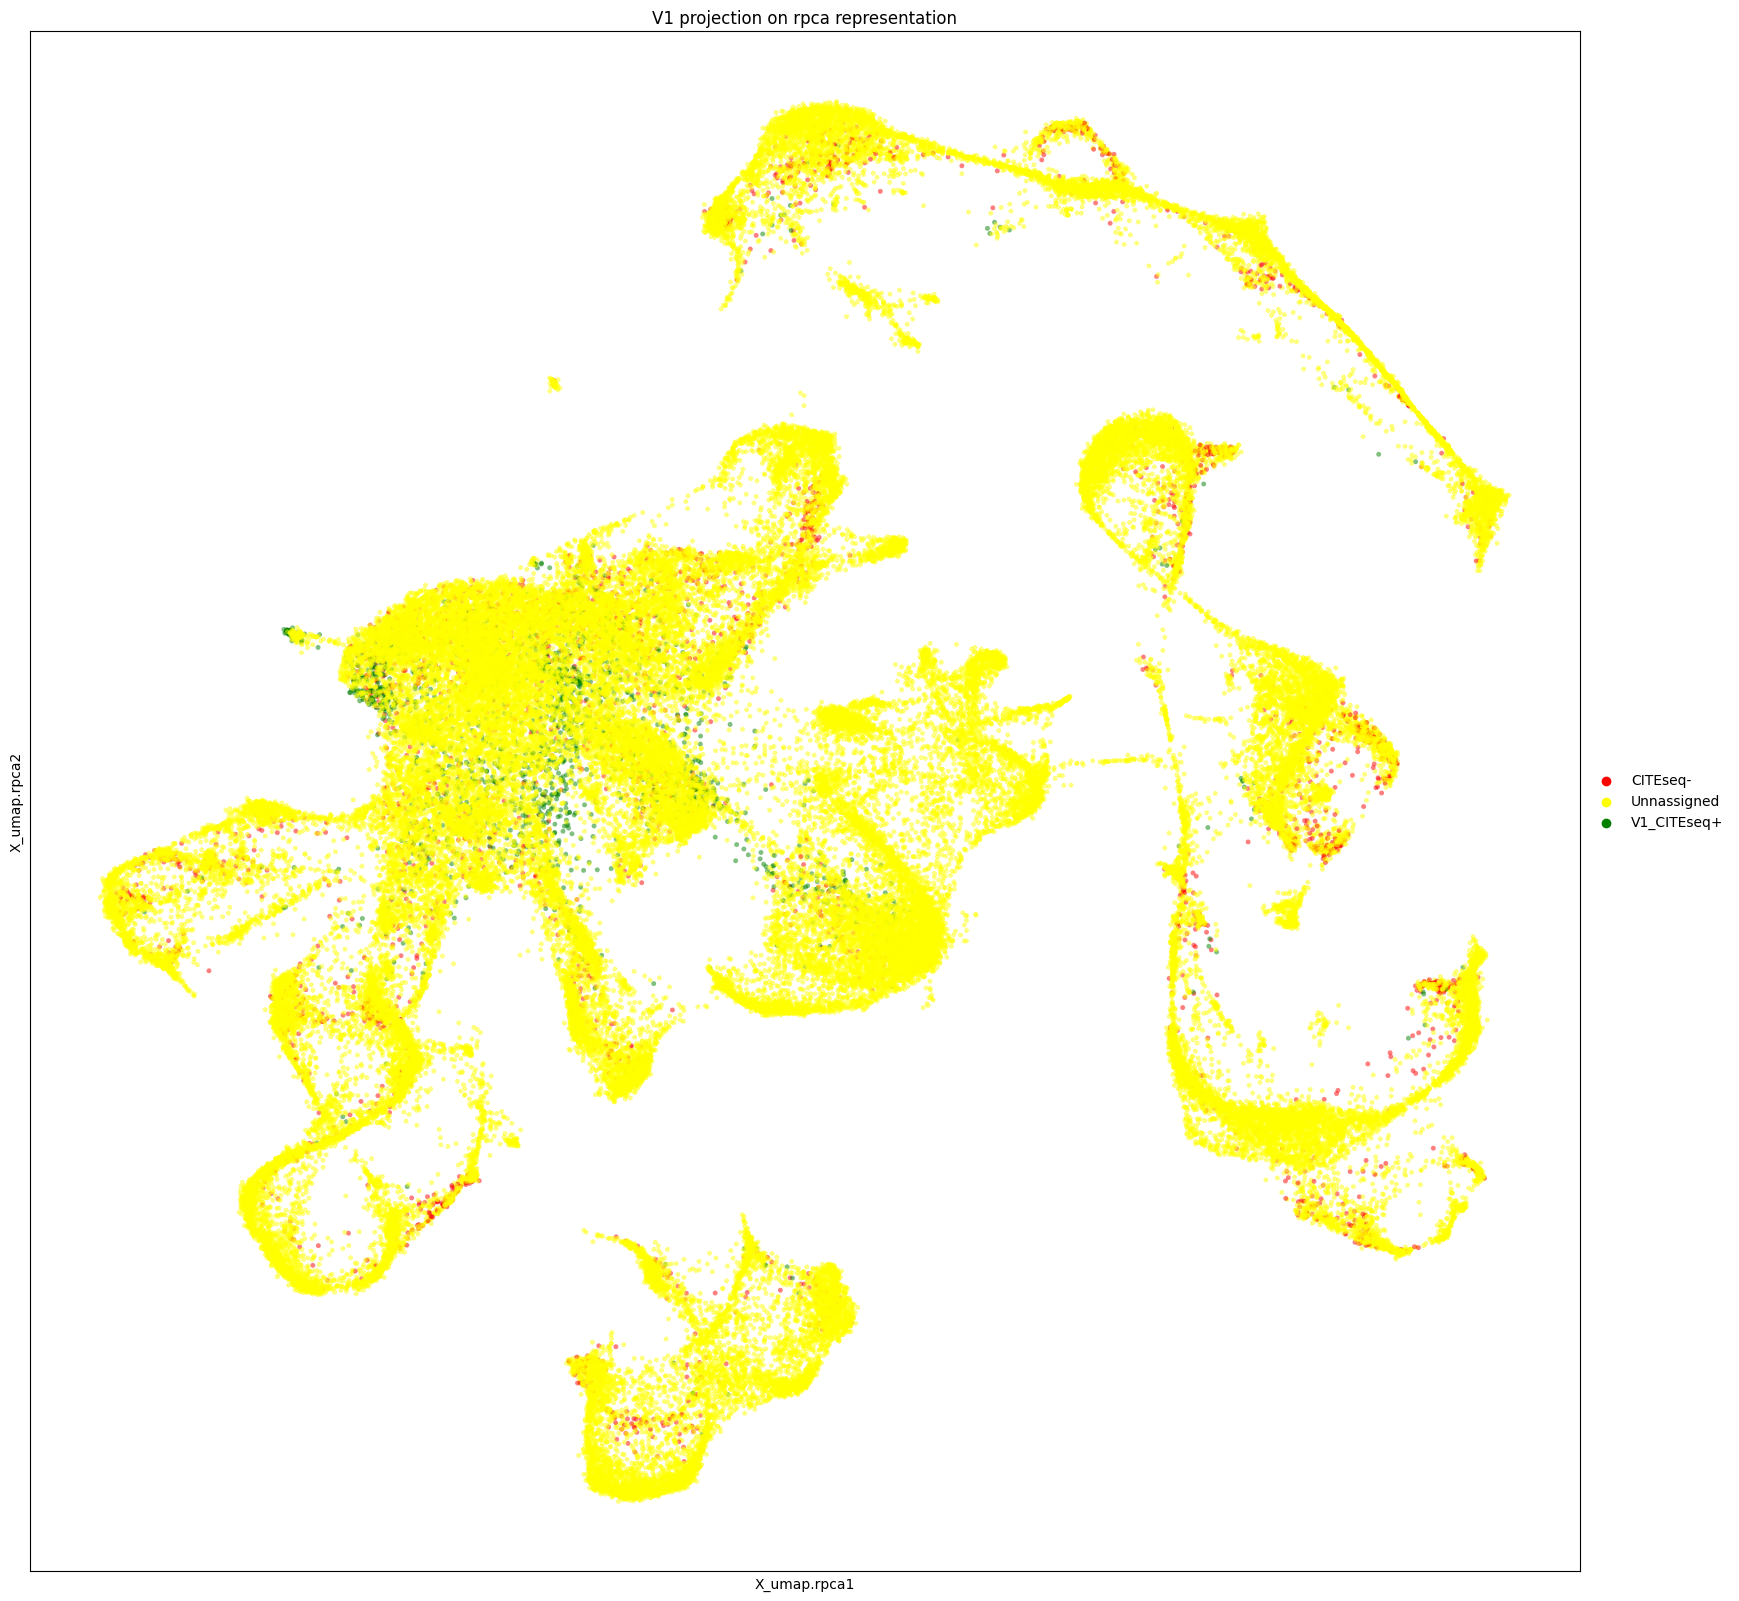

In [20]:
integrated.uns['annotation_colors'] = ['red', 'yellow', 'green']
fig, ax = plt.subplots(1,1, figsize = (20,20))

sc.pl.embedding(integrated, basis = 'X_umap.rpca', color='annotation', title = 'V1 projection on rpca representation', ax = ax, size = 50, alpha = 0.5)

## Training

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

In [22]:
# Split data

train_data = integrated[integrated.obs['training_labels'] != -1]

X = train_data.X
y = train_data.obs['training_labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [23]:
# Plot sizes 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4068, 2000)
(1017, 2000)
(4068,)
(1017,)


In [24]:
# Look at the distribution of the training labels
y_train.value_counts()

training_labels
0.0    2597
1.0    1471
Name: count, dtype: int64

In [25]:
# Train an xgb classifier
xgb = XGBClassifier()

In [36]:
# Grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05,0.1],
    'n_estimators': [100, 150, 200]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\Emile\AppData\Local\Programs\Python\Pyt

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [4, 5, 6],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [37]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
# Train best xgb model
xgb_best = XGBClassifier(learning_rate = 0.03, max_depth = 5, n_estimators = 200)
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
# Compute cross-validation
xgb = XGBClassifier(learning_rate = 0.03, max_depth = 5, n_estimators = 200)
scores = cross_val_score(xgb, X, y, cv=5)
scores

array([0.96165192, 0.95771878, 0.9567355 , 0.95968535, 0.96460177])

In [47]:
# Compute cross validation scores function of the learning rate
lr = np.linspace(0.005, 0.1, 15)
cvl = [] 
for r in lr:
    xgb = XGBClassifier(learning_rate = r, max_depth = 5, n_estimators = 200)
    cvl.append(cross_val_score(xgb, X, y, cv = 5))

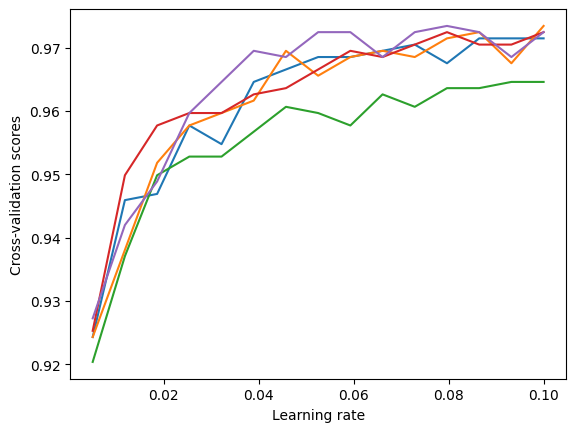

In [49]:
fig, ax = plt.subplots(1,1)
ax.plot(lr, cvl)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Cross-validation scores')
fig.savefig('figures/learning_curves.svg')
plt.show()


In [82]:
lr_2 = np.linspace(0.2, 1.5, 10)
for r in lr_2:
    xgb = XGBClassifier(learning_rate = r, max_depth = 5, n_estimators = 200)
    cvl.append(cross_val_score(xgb, X, y, cv = 5))

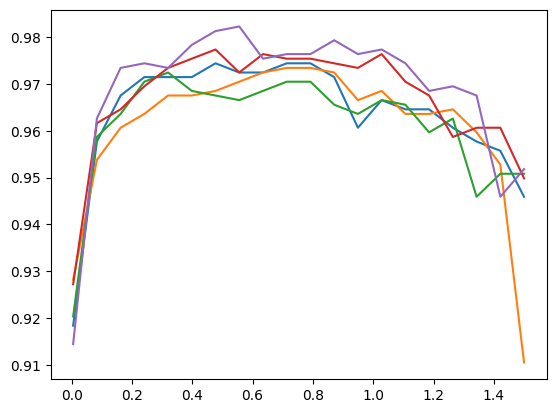

In [86]:
plt.plot(np.linspace(0.005,1.5,20),cvl)
plt.show()

In [16]:
y_pred_xgb = xgb_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 96.95%
F1: 95.63%


In [32]:
y_score = xgb_best.predict_proba(X_test)
y_score = y_score[:,1]

In [42]:
fpr, tpr, tresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

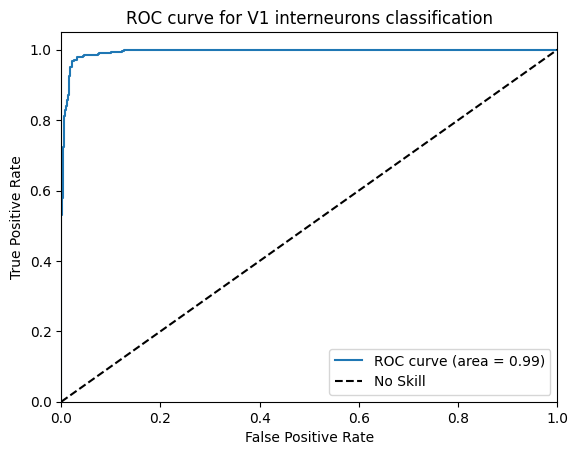

In [45]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC curve for V1 interneurons classification')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('figures/roc_curve.svg')
plt.show()

### Plot the most important features for classification

#### Compare the features across the dataset using cross-validation

In [32]:
def plot_best_features(model, train_data, n = 20):
    """Plots the most important features for classification"""
    best_features_indexes = np.argsort(model.feature_importances_)[-n:]
    best_features = train_data.var_names[best_features_indexes]
    fig, ax = plt.subplots(1,1, figsize = (20,9))
    ax.bar(best_features,model.feature_importances_[best_features_indexes])
    plt.xlabel('Feature genes')
    plt.ylabel('Feature importance')
    fig.savefig('figures/feature_importance.svg')
    plt.show()

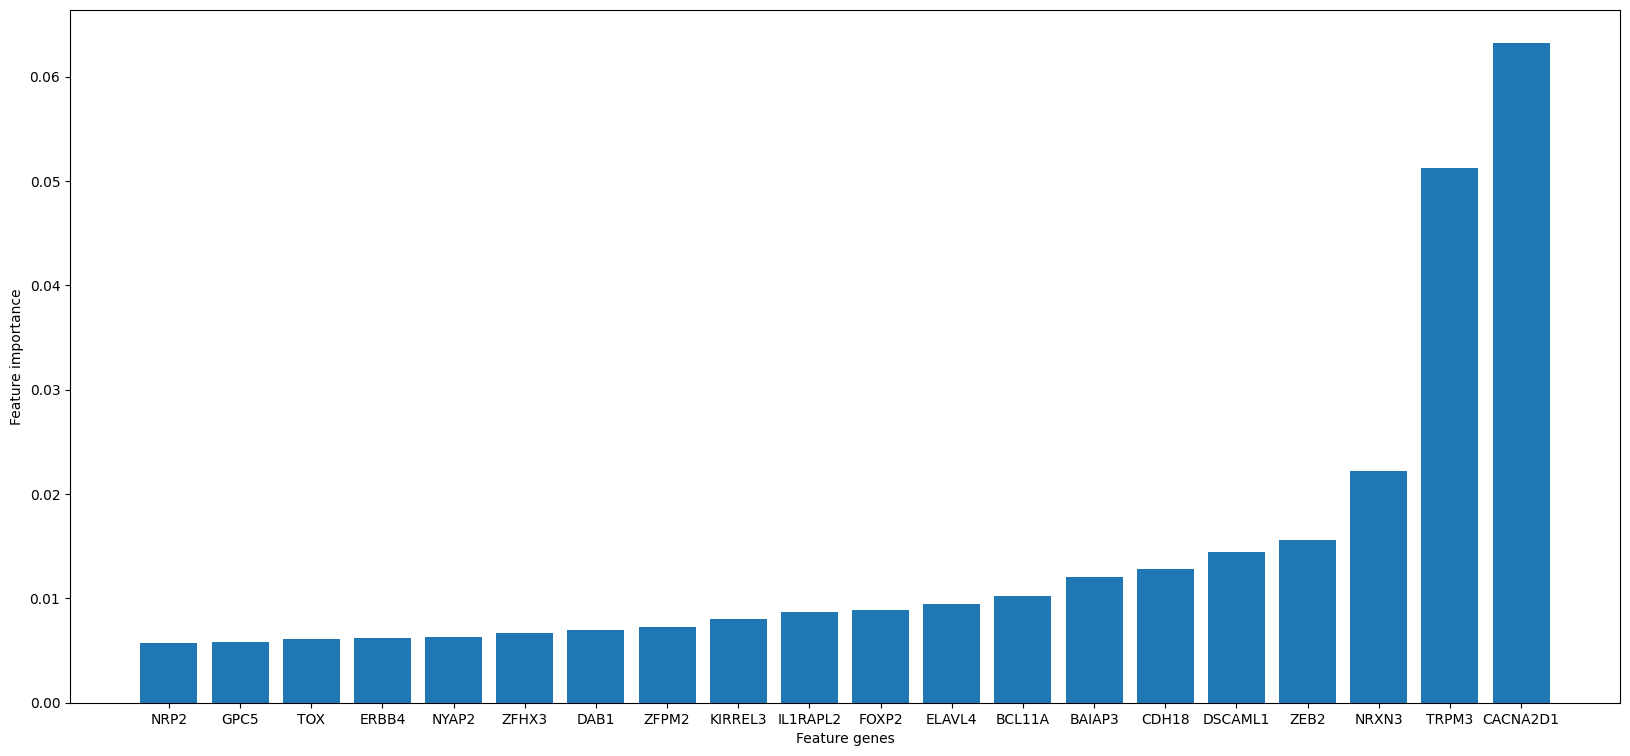

In [33]:
plot_best_features(xgb_best, train_data)

Fold 0:
  Train: index=[   1    2    3 ... 5082 5083 5084]
  Test:  index=[   0    4    6 ... 5065 5066 5077]
####### Training finished #######
True Negative:  628
False Positive:  26
False Negative:  15
True Positive:  348
Accuracy:  0.95968534906588
F1_score:  0.9443690637720489
Looking at best features.......


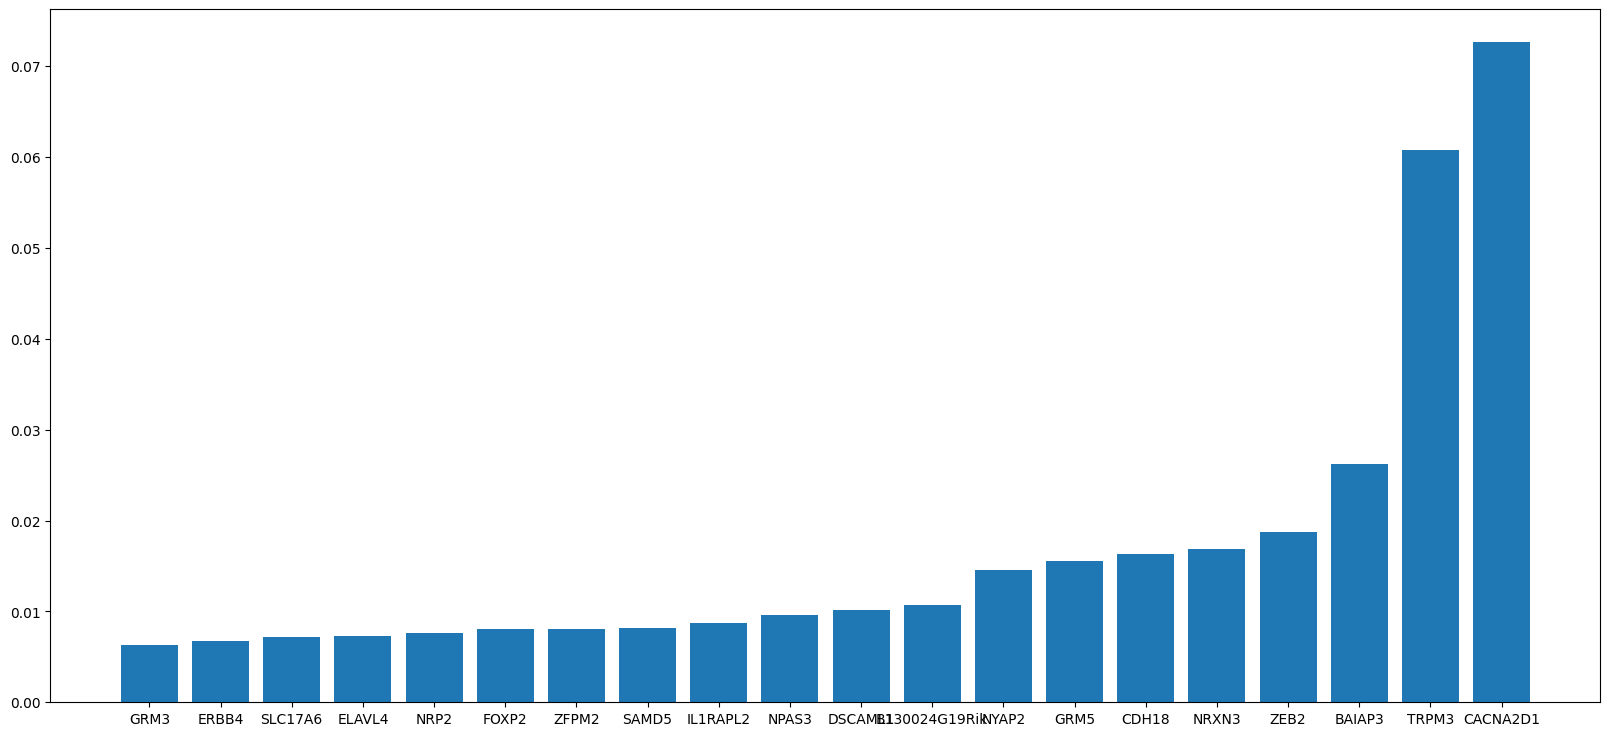

Fold 1:
  Train: index=[   0    2    4 ... 5080 5081 5083]
  Test:  index=[   1    3   10 ... 5076 5082 5084]
####### Training finished #######
True Negative:  640
False Positive:  21
False Negative:  5
True Positive:  351
Accuracy:  0.9744346116027532
F1_score:  0.9642857142857143
Looking at best features.......


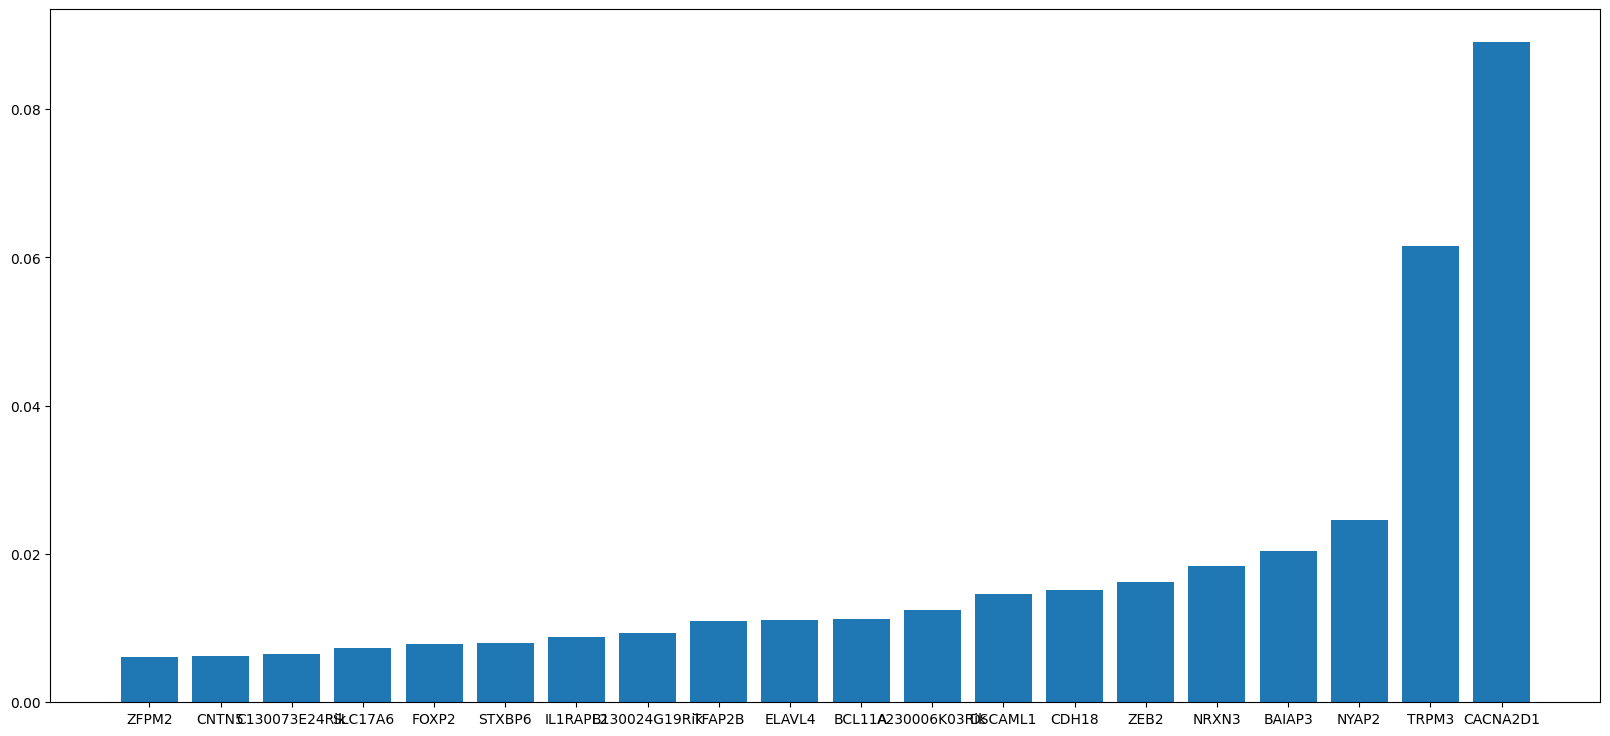

Fold 2:
  Train: index=[   0    1    3 ... 5081 5082 5084]
  Test:  index=[   2   11   17 ... 5073 5074 5083]
####### Training finished #######
True Negative:  624
False Positive:  26
False Negative:  7
True Positive:  360
Accuracy:  0.967551622418879
F1_score:  0.9561752988047809
Looking at best features.......


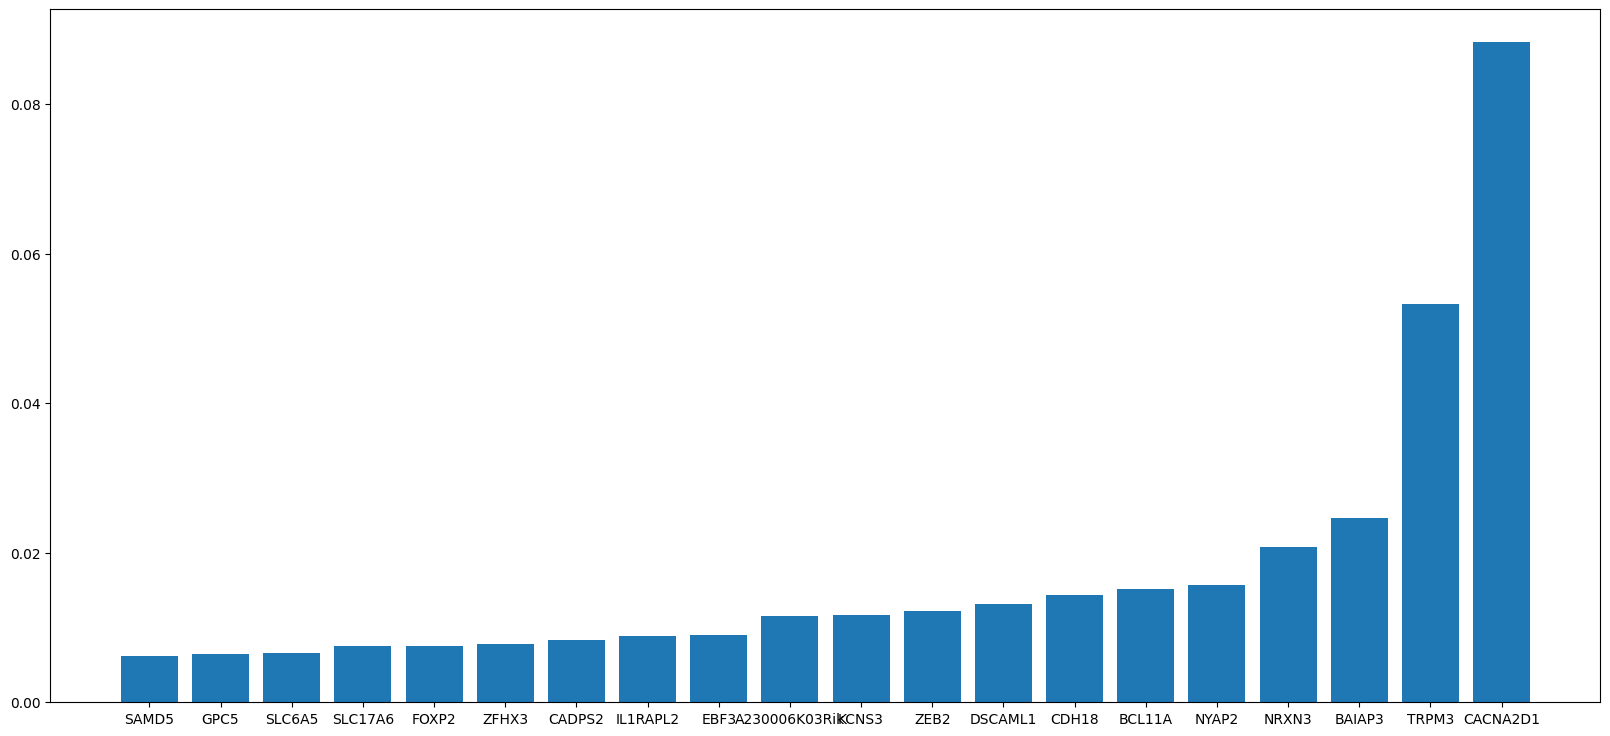

Fold 3:
  Train: index=[   0    1    2 ... 5082 5083 5084]
  Test:  index=[   5   14   31 ... 5075 5079 5080]
####### Training finished #######
True Negative:  624
False Positive:  21
False Negative:  9
True Positive:  363
Accuracy:  0.9705014749262537
F1_score:  0.9603174603174603
Looking at best features.......


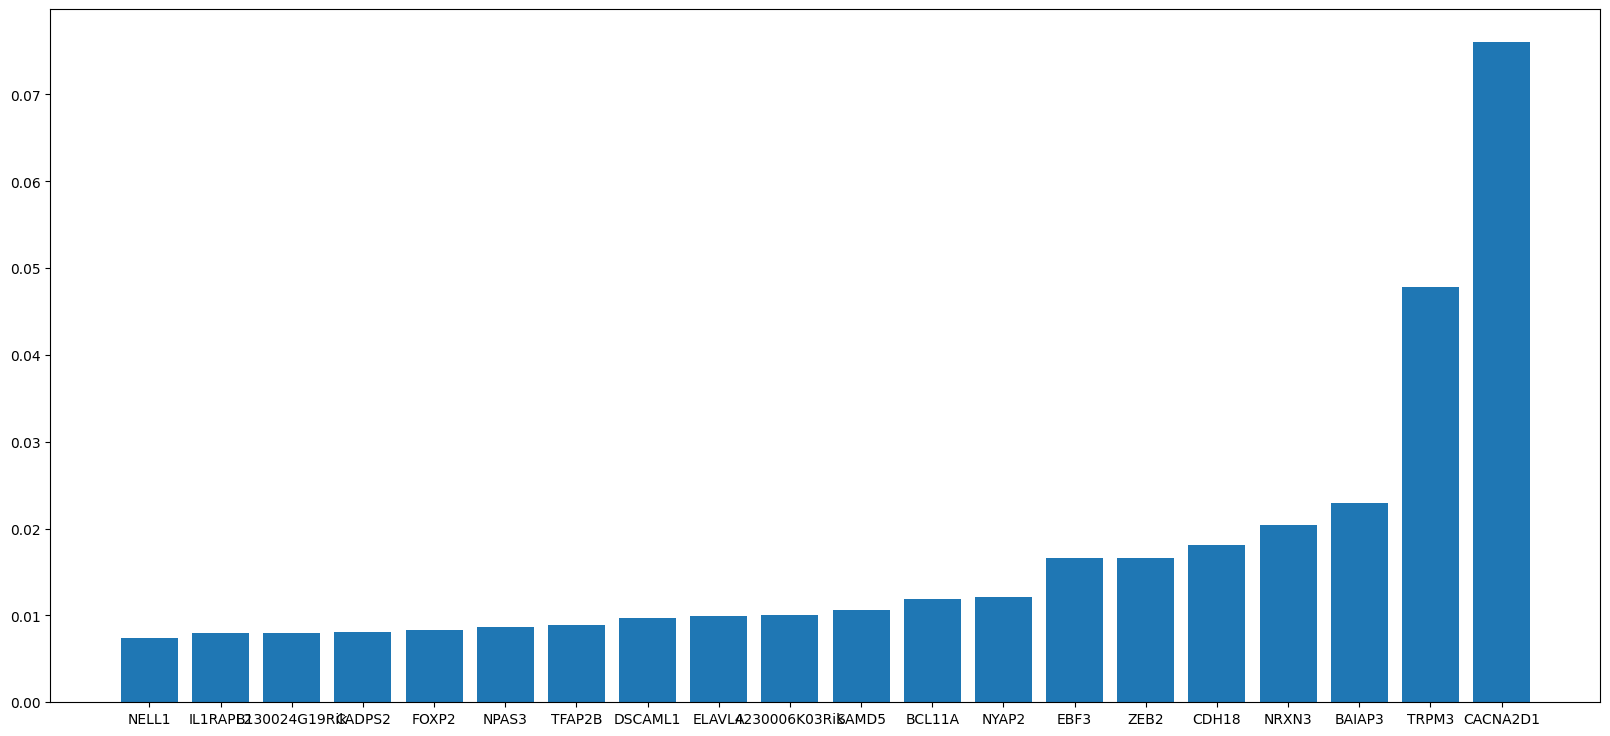

Fold 4:
  Train: index=[   0    1    2 ... 5082 5083 5084]
  Test:  index=[   8   12   13 ... 5072 5078 5081]
####### Training finished #######
True Negative:  637
False Positive:  18
False Negative:  11
True Positive:  351
Accuracy:  0.9714847590953786
F1_score:  0.960328317373461
Looking at best features.......


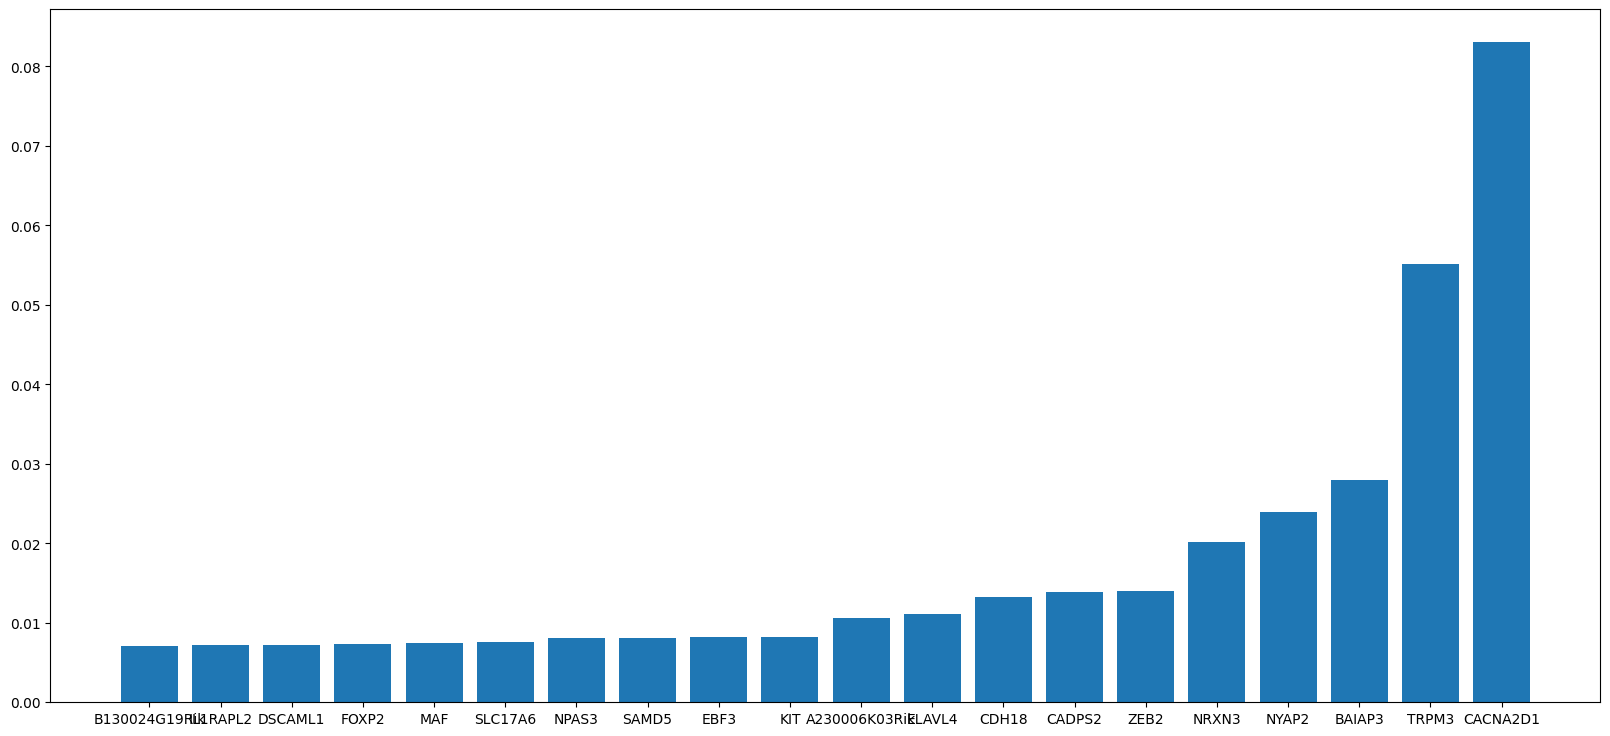

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

kf = KFold(shuffle = True)
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    xgb = XGBClassifier(learning_rate = 0.05, max_depth = 5, n_estimators = 200, random_state = 1)
    xgb.fit(X[train_index], y.iloc[train_index])
    print("####### Training finished #######")
    y_pred_test = xgb.predict(X[test_index])
    tn, fp, fn, tp = confusion_matrix(y.iloc[test_index], y_pred_test).ravel()
    print('True Negative: ', tn)
    print('False Positive: ', fp)
    print('False Negative: ', fn)
    print('True Positive: ', tp)
    print('Accuracy: ', accuracy_score(y.iloc[test_index], y_pred_test))
    print('F1_score: ', f1_score(y.iloc[test_index], y_pred_test))
    print("Looking at best features.......")
    plot_best_features(xgb, train_data)

### Train an SVM

In [14]:
# Train an svm 

from sklearn.svm import SVC

svm = SVC(kernel = 'rbf', probability=True)

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 97.44%
F1: 96.36%


In [33]:
scores = cross_val_score(svm, X, y, cv=5)
scores

array([0.97148476, 0.96951819, 0.9626352 , 0.96755162, 0.97640118])

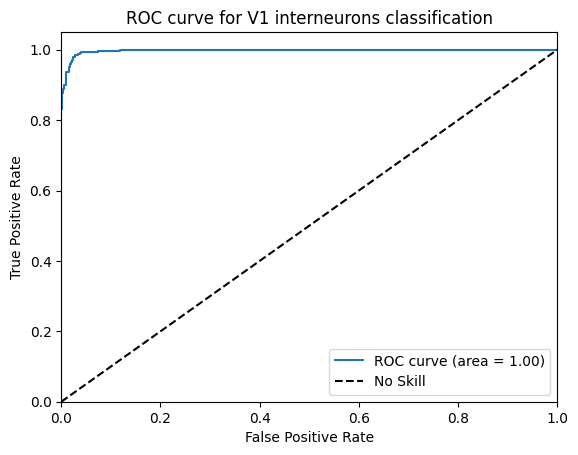

In [16]:
y_score = svm.predict_proba(X_test)
y_score = y_score[:,1]
fpr, tpr, tresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC curve for V1 interneurons classification')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('figures/roc_curve_svm.svg')
plt.show()

### Train a knn classifier

In [34]:
# Train a knn classifier on PCA data

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 77.97%
F1: 56.59%


In [35]:
# Look number of predicted labels
print(pd.Series(y_pred_xgb).value_counts())
print(pd.Series(y_pred_svm).value_counts())
print(pd.Series(y_pred_knn).value_counts())


0    657
1    360
Name: count, dtype: int64
0.0    652
1.0    365
Name: count, dtype: int64
0.0    850
1.0    167
Name: count, dtype: int64


In [28]:
xgb_best.save_model("models/xgb_cross_species_annotation.json")

In [ ]:
xgb_best = XGBClassifier()
xgb_best.load_model("models/xgb_cross_species_annotation.json")

### SCCAF

In [ ]:
# Try the SCCAF model (used in an other cross-species paper)
import SCCAF

In [ ]:
y_prob2, y_pred2, y_test2, clf2, cvsm2, acc2 = SCCAF.SCCAF_assessment(X, y, classifier = 'SVM', fraction = 0.8, n = 6000)

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\SCCAF\__init__.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return X[c_idx, :], X[d_idx, :], y[c_idx], y[d_idx]


Mean CV accuracy: 0.9469
Accuracy on the training set: 0.9990
Accuracy on the hold-out set: 0.9503


In [ ]:
y_pred_sccaf = clf2.predict(X_all)

In [ ]:
pd.DataFrame(y_pred_sccaf).value_counts()

0  
0.0    62948
1.0     4904
Name: count, dtype: int64

In [ ]:
integrated.obs['predicted_labels_sccaf'] = y_pred_sccaf
integrated.obs['predicted_labels_sccaf'] = integrated.obs['predicted_labels_sccaf'].astype('category')

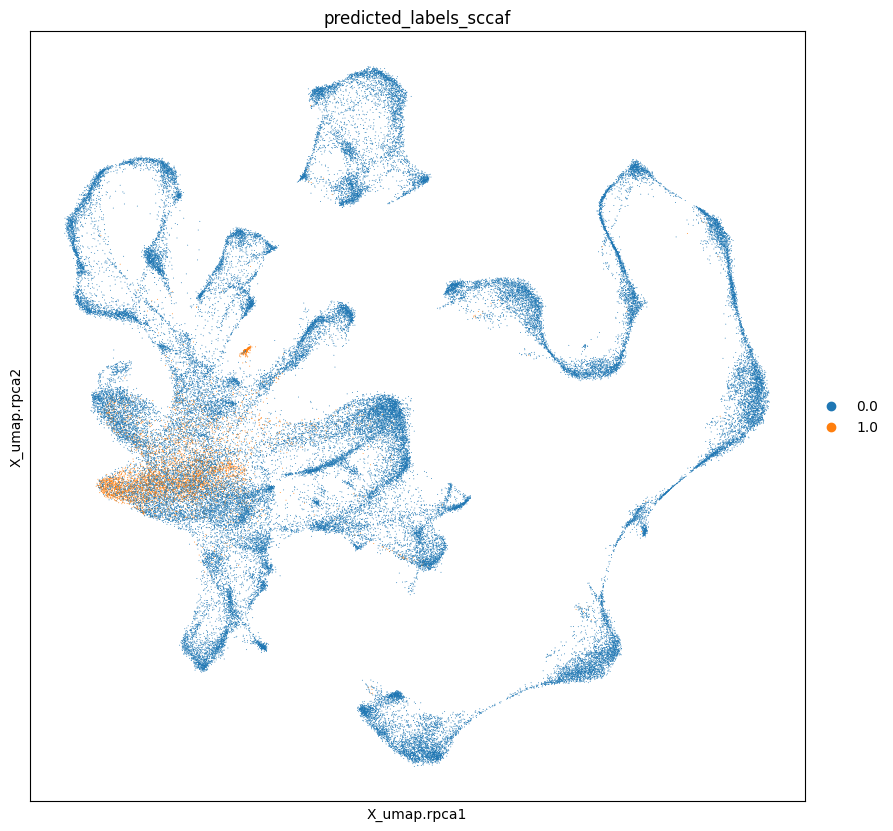

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(integrated, basis = 'X_umap.rpca', color='predicted_labels_sccaf', ax = ax)

## Prediction

In [26]:
# Predict on all data
X_all = integrated.X

y_pred_all_xgb = xgb_best.predict(X_all)
# y_pred_all_svm = svm.predict(X_all)
# y_pred_all_knn = knn.predict(X_all)


# Add predictions to the integrated object
integrated.obs['predicted_labels_xgb'] = y_pred_all_xgb
# integrated.obs['predicted_labels_svm'] = y_pred_all_svm
# integrated.obs['predicted_labels_knn'] = y_pred_all_knn


In [27]:
# Look at the distribution of the predicted labels
print('XGB:')
print(pd.Series(y_pred_all_xgb).value_counts())
# print('SVM:')
# print(pd.Series(y_pred_all_svm).value_counts())
# print('KNN:')
# print(pd.Series(y_pred_all_knn).value_counts())

XGB:
0    79876
1     5634
Name: count, dtype: int64


In [28]:
# Labels as categories
integrated.obs['predicted_labels_xgb'] = integrated.obs['predicted_labels_xgb'].astype('category')
# integrated.obs['predicted_labels_svm'] = integrated.obs['predicted_labels_svm'].astype('category')
# integrated.obs['predicted_labels_knn'] = integrated.obs['predicted_labels_knn'].astype('category')


c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\plotting\_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


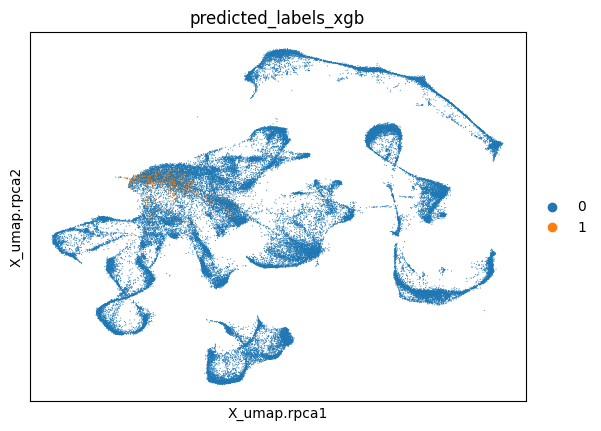

In [29]:
# Plot only human neurons
# sc.pl.embedding(integrated[integrated.obs['species'] == 'human'], basis = 'X_umap.rpca', color=['predicted_labels_xgb', 'predicted_labels_svm', 'predicted_labels_knn'])
sc.pl.embedding(integrated[integrated.obs['species'] == 'human'], basis = 'X_umap.rpca', color='predicted_labels_xgb')

In [15]:
integrated.obs['predicted_annotation'] = integrated.obs['predicted_labels_xgb'].apply(lambda x: 'V1_predicted' if x == 1 else 'Not_V1_predicted')

KeyError: 'predicted_labels_xgb'

In [18]:
integrated = sc.read_h5ad(ROOT + 'data/annotated_data/cross_species_all_sets_common_genes_final.h5ad')

In [26]:
integrated.uns['predicted_annotation_colors'] = ['red', 'green']

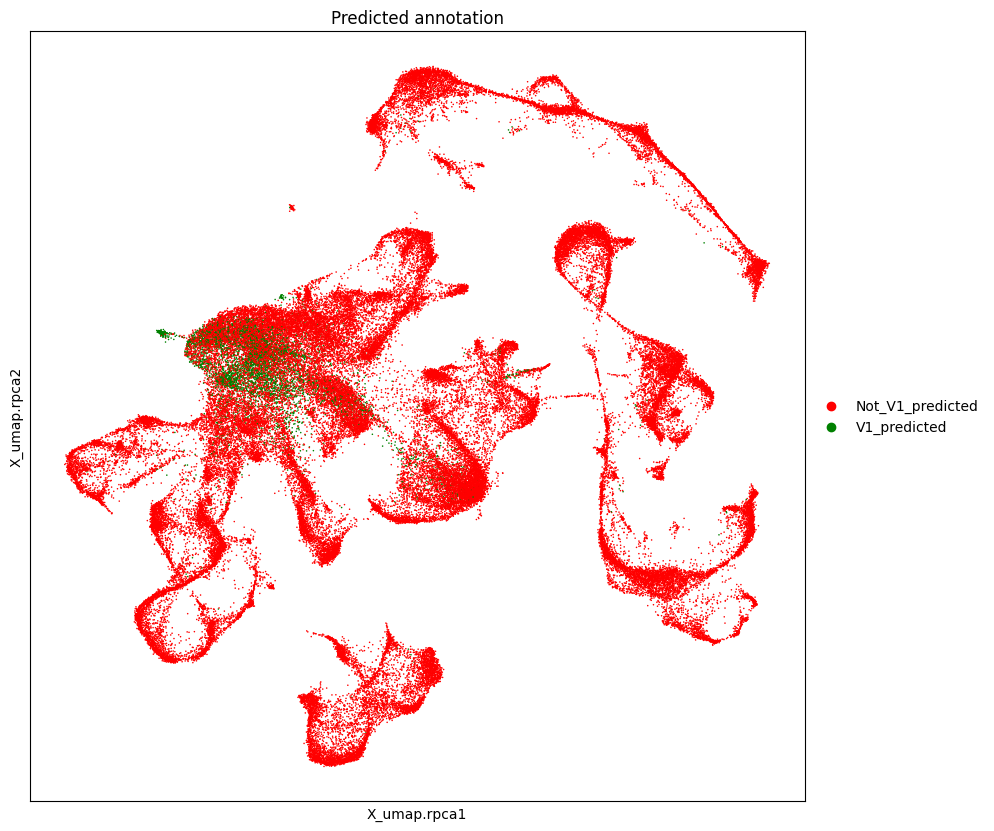

In [27]:
## Plotting
fig, ax = plt.subplots(1,1, figsize = (10,10))

sc.pl.embedding(integrated, basis = 'X_umap.rpca', color='predicted_annotation', title = 'Predicted annotation', ax = ax, size = 5)

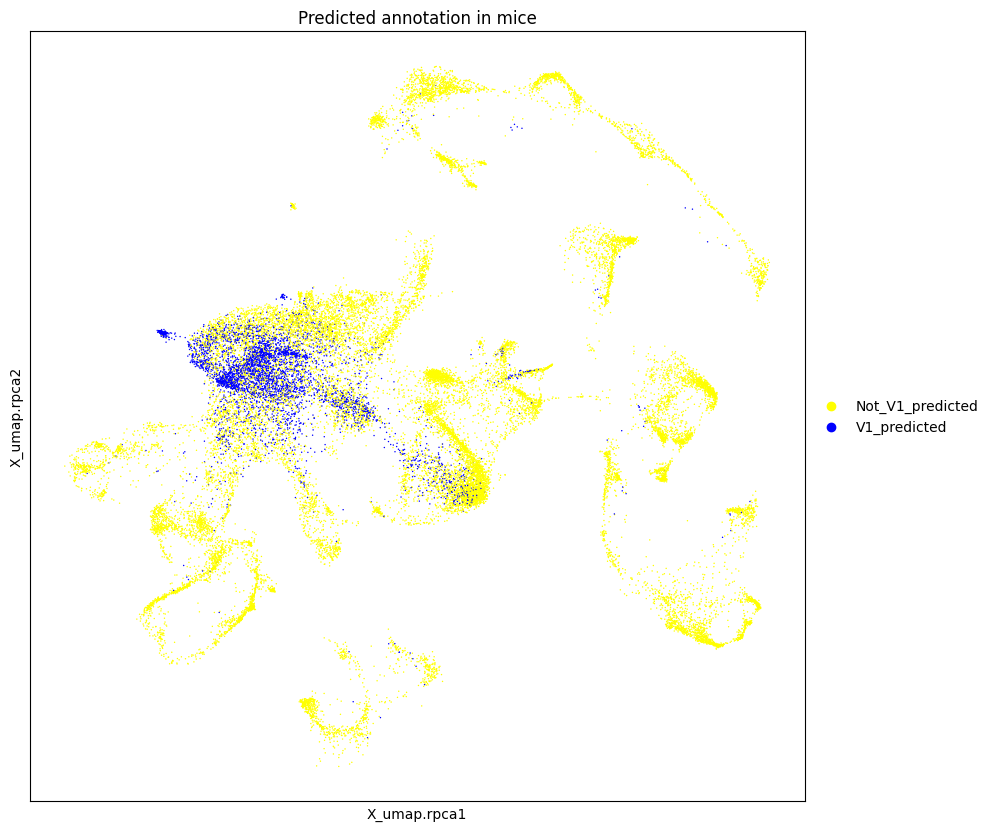

In [33]:
## Plotting
fig, ax = plt.subplots(1,1, figsize = (10,10))

sc.pl.embedding(integrated[integrated.obs['species'] == 'mouse'], basis = 'X_umap.rpca', color='predicted_annotation', title = 'Predicted annotation in mice', ax = ax)

In [34]:
integrated[integrated.obs['species'] == 'mouse'].obs['predicted_annotation'].value_counts()

predicted_annotation
Not_V1_predicted    23819
V1_predicted         4402
Name: count, dtype: int64

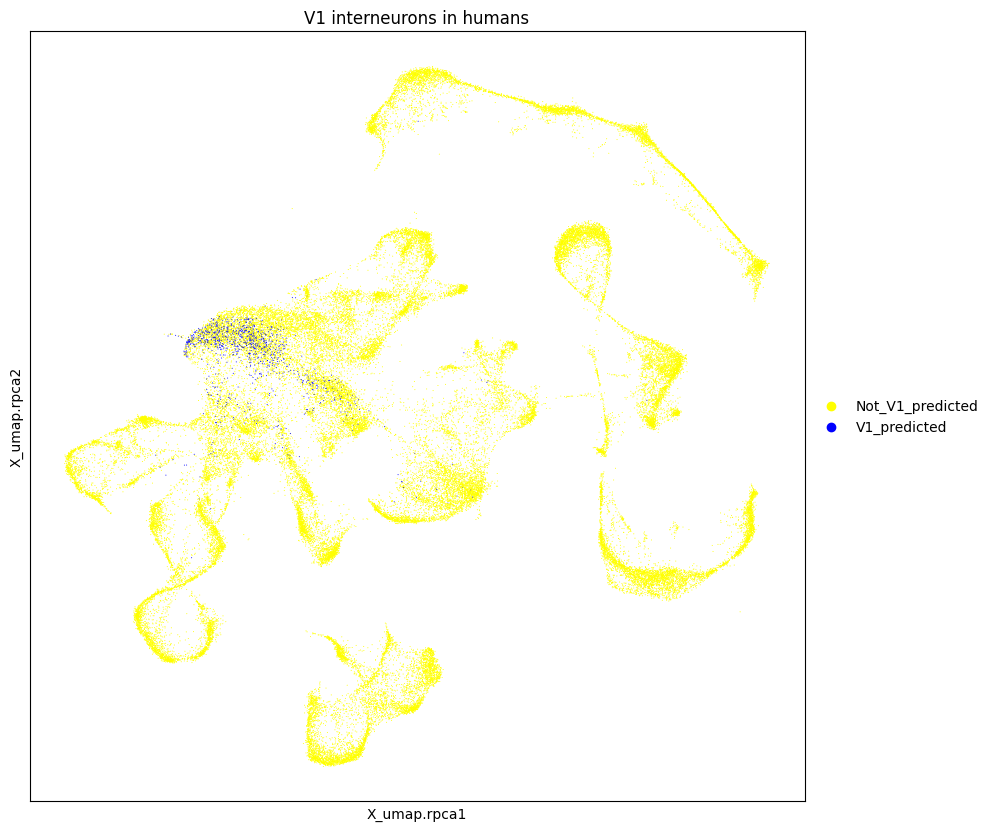

In [35]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(integrated[integrated.obs['species'] == 'human'], basis = 'X_umap.rpca', color='predicted_annotation', title = 'V1 interneurons in humans', ax = ax)

In [36]:
integrated[integrated.obs['species'] == 'human']

View of AnnData object with n_obs × n_vars = 57289 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'annotation', 'predicted_labels_xgb', 'predicted_annotation'
    uns: 'orig.ident_colors', 'species_colors', 'annotation_colors', 'predicted_annotation_colors'
    obsm: 'X_pca', 'X_rpca', 'X_umap.rpca'

In [37]:
integrated[integrated.obs['species'] == 'human'].obs['predicted_annotation'].value_counts()

predicted_annotation
Not_V1_predicted    56057
V1_predicted         1232
Name: count, dtype: int64

In [38]:
# # Save annotated anndata
integrated.write(ROOT + 'data/annotated_data/cross_species_all_sets_common_genes_final.h5ad')

## Exploring results

In [39]:
counts_xgb_mouse = integrated[integrated.obs['species'] == 'mouse'].obs.groupby(['orig.ident', 'predicted_labels_xgb' ]).size().unstack(fill_value=0)
print(counts_xgb_mouse)
counts_xgb_human = integrated[integrated.obs['species'] == 'human'].obs.groupby(['orig.ident', 'predicted_labels_xgb' ]).size().unstack(fill_value=0)
print(counts_xgb_human)

C:\Users\Emile\AppData\Local\Temp\ipykernel_12040\189823693.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_xgb_mouse = integrated[integrated.obs['species'] == 'mouse'].obs.groupby(['orig.ident', 'predicted_labels_xgb' ]).size().unstack(fill_value=0)


predicted_labels_xgb     0     1
orig.ident                      
BOUV5                 1404    13
GSE7474501            3966   294
GSM7474503            6621   163
KATHE                 2258    73
KNAF3                 3238    27
KNAF4                   10  1810
KNAF13                4090  1949
MATSON                2232    73


C:\Users\Emile\AppData\Local\Temp\ipykernel_12040\189823693.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_xgb_human = integrated[integrated.obs['species'] == 'human'].obs.groupby(['orig.ident', 'predicted_labels_xgb' ]).size().unstack(fill_value=0)


predicted_labels_xgb              0    1
orig.ident                              
KNAF8                          9225   70
KNAF9                          5087   66
KNAF10_Humain-P12_NeuN_221124  1658   24
KNAF11_Humain-P13_NeuN_221124  2528   70
KNAF12_Humain-P11_NeuN_180325  8423  265
KNAF14                         5484  222
KNAF15                         5712  239
KNAF16_Humain-P10_NeuN_130525  4716  106
KNAF17_Humain-P8_NeuN_130525   6032  144
YADAV                          3536   19
ZHANG                          3656    7


In [40]:
counts_xgb_human['species'] = 'human'
counts_xgb_mouse['species'] = 'mouse'

In [41]:
counts = pd.concat([counts_xgb_human, counts_xgb_mouse])
counts

predicted_labels_xgb              0     1 species
orig.ident                                       
KNAF8                          9225    70   human
KNAF9                          5087    66   human
KNAF10_Humain-P12_NeuN_221124  1658    24   human
KNAF11_Humain-P13_NeuN_221124  2528    70   human
KNAF12_Humain-P11_NeuN_180325  8423   265   human
KNAF14                         5484   222   human
KNAF15                         5712   239   human
KNAF16_Humain-P10_NeuN_130525  4716   106   human
KNAF17_Humain-P8_NeuN_130525   6032   144   human
YADAV                          3536    19   human
ZHANG                          3656     7   human
BOUV5                          1404    13   mouse
GSE7474501                     3966   294   mouse
GSM7474503                     6621   163   mouse
KATHE                          2258    73   mouse
KNAF3                          3238    27   mouse
KNAF4                            10  1810   mouse
KNAF13                         4090  1949   mouse
MATSON                         2232    73   mouse

In [42]:
# Count labels per orig.ident in one dataframe
def compute_props(counts):
    counts = counts.rename(columns={0: 'NeuronOnly', 1: 'V1', -1: 'Unassigned'})
    counts = counts.rename_axis(None, axis=1).reset_index()
    counts['proportion'] = counts['V1'] / (counts['V1'] + counts['NeuronOnly'])
    # Reorder columns
    counts = counts[['orig.ident', 'species', 'NeuronOnly', 'V1', 'proportion']]
    # Drop index
    counts = counts.reset_index(drop=True)
    return counts

In [43]:
counts_xgb = compute_props(counts)
counts_xgb.sort_values(by = 'species')

orig.ident species  NeuronOnly    V1  proportion
0                           KNAF8   human        9225    70    0.007531
10                          ZHANG   human        3656     7    0.001911
8    KNAF17_Humain-P8_NeuN_130525   human        6032   144    0.023316
7   KNAF16_Humain-P10_NeuN_130525   human        4716   106    0.021983
6                          KNAF15   human        5712   239    0.040161
9                           YADAV   human        3536    19    0.005345
4   KNAF12_Humain-P11_NeuN_180325   human        8423   265    0.030502
3   KNAF11_Humain-P13_NeuN_221124   human        2528    70    0.026944
2   KNAF10_Humain-P12_NeuN_221124   human        1658    24    0.014269
1                           KNAF9   human        5087    66    0.012808
5                          KNAF14   human        5484   222    0.038906
17                         KNAF13   mouse        4090  1949    0.322736
11                          BOUV5   mouse        1404    13    0.009174
12                     GSE7474501   mouse        3966   294    0.069014
13                     GSM7474503   mouse        6621   163    0.024027
14                          KATHE   mouse        2258    73    0.031317
15                          KNAF3   mouse        3238    27    0.008270
16                          KNAF4   mouse          10  1810    0.994505
18                         MATSON   mouse        2232    73    0.031670

In [44]:
counts_xgb[counts_xgb['species'] == 'human']['V1'].sum()

np.int64(1232)

In [66]:
counts_xgb[counts_xgb['species'] == 'human']['NeuronOnly'].sum()

np.int64(41749)

In [57]:
counts_svm = integrated.obs.groupby(['orig.ident', 'predicted_labels_svm']).size().unstack(fill_value=0)
counts_svm = compute_props(counts_svm)
counts_svm.sort_values(by = 'species')

C:\Users\Emile\AppData\Local\Temp\ipykernel_39284\3790939744.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_svm = integrated.obs.groupby(['orig.ident', 'predicted_labels_svm']).size().unstack(fill_value=0)


orig.ident species  NeuronOnly    V1  proportion
8     KNAF10_Humain-P12_NeuN_221124   human        1680     2    0.001189
13  KNAF15_Humain-P15_NeuN_b_280325   human        5788   163    0.027390
12  KNAF14_Humain-P15_NeuN_a_280325   human        5586   120    0.021030
10    KNAF12_Humain-P11_NeuN_180325   human        8629    59    0.006791
9     KNAF11_Humain-P13_NeuN_221124   human        2562    36    0.013857
15                            YADAV   human        3555     0    0.000000
7      KNAF9_Humain-P13_NeuN_021024   human        2794     5    0.001786
16                            ZHANG   human        3662     1    0.000273
6      KNAF8_Humain-P12_NeuN_021024   human        4983     6    0.001203
5                             KNAF4   mouse           9  1811    0.995055
4                             KNAF3   mouse        3239    26    0.007963
3                             KATHE   mouse        2303    28    0.012012
11                           KNAF13   mouse        4113  1926    0.318927
2                        GSM7474503   mouse        6744    40    0.005896
1                        GSE7474501   mouse        4126   134    0.031455
14                           MATSON   mouse        2283    22    0.009544
0                             BOUV5   mouse        1407    10    0.007057

In [66]:
counts_knn = integrated.obs.groupby(['orig.ident', 'predicted_labels_knn']).size().unstack(fill_value=0)
counts_knn = compute_props(counts_knn)
counts_knn.sort_values(by='species')

C:\Users\Emile\AppData\Local\Temp\ipykernel_39284\783153013.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_knn = integrated.obs.groupby(['orig.ident', 'predicted_labels_knn']).size().unstack(fill_value=0)


orig.ident species  NeuronOnly    V1  proportion
8     KNAF10_Humain-P12_NeuN_221124   human        1652    30    0.017836
13  KNAF15_Humain-P15_NeuN_b_280325   human        5943     8    0.001344
12  KNAF14_Humain-P15_NeuN_a_280325   human        5694    12    0.002103
10    KNAF12_Humain-P11_NeuN_180325   human        8645    43    0.004949
9     KNAF11_Humain-P13_NeuN_221124   human        2576    22    0.008468
15                            YADAV   human        3530    25    0.007032
7      KNAF9_Humain-P13_NeuN_021024   human        2795     4    0.001429
16                            ZHANG   human        3628    35    0.009555
6      KNAF8_Humain-P12_NeuN_021024   human        4981     8    0.001604
5                             KNAF4   mouse         900   920    0.505495
4                             KNAF3   mouse        3223    42    0.012864
3                             KATHE   mouse        2329     2    0.000858
11                           KNAF13   mouse        4847  1192    0.197384
2                        GSM7474503   mouse        6635   149    0.021963
1                        GSE7474501   mouse        4022   238    0.055869
14                           MATSON   mouse        2303     2    0.000868
0                             BOUV5   mouse        1378    39    0.027523

In [67]:
counts_sccaf = integrated.obs.groupby(['orig.ident', 'predicted_labels_sccaf']).size().unstack(fill_value=0)
counts_sccaf = compute_props(counts_sccaf)
counts_sccaf.sort_values(by='species')

C:\Users\Emile\AppData\Local\Temp\ipykernel_39284\1976723443.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_sccaf = integrated.obs.groupby(['orig.ident', 'predicted_labels_sccaf']).size().unstack(fill_value=0)


orig.ident species  NeuronOnly    V1  proportion
8     KNAF10_Humain-P12_NeuN_221124   human        1665    17    0.010107
13  KNAF15_Humain-P15_NeuN_b_280325   human        5672   279    0.046883
12  KNAF14_Humain-P15_NeuN_a_280325   human        5501   205    0.035927
10    KNAF12_Humain-P11_NeuN_180325   human        8548   140    0.016114
9     KNAF11_Humain-P13_NeuN_221124   human        2519    79    0.030408
15                            YADAV   human        3554     1    0.000281
7      KNAF9_Humain-P13_NeuN_021024   human        2791     8    0.002858
16                            ZHANG   human        3662     1    0.000273
6      KNAF8_Humain-P12_NeuN_021024   human        4977    12    0.002405
5                             KNAF4   mouse          75  1745    0.958791
4                             KNAF3   mouse        3137   128    0.039204
3                             KATHE   mouse        2314    17    0.007293
11                           KNAF13   mouse        4050  1989    0.329359
2                        GSM7474503   mouse        6740    44    0.006486
1                        GSE7474501   mouse        4056   204    0.047887
14                           MATSON   mouse        2289    16    0.006941
0                             BOUV5   mouse        1398    19    0.013409

In [69]:
# Plot mouse V1 against human V1
mouse_v1 = integrated[(integrated.obs['species'] == 'mouse') & (integrated.obs['predicted_labels_xgb'] == 1)]
human_v1 = integrated[(integrated.obs['species'] == 'human') & (integrated.obs['predicted_labels_xgb'] == 1)]
comparison = sc.concat([mouse_v1, human_v1])
comparison

AnnData object with n_obs × n_vars = 5181 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'annotation', 'predicted_labels_xgb', 'predicted_labels_svm', 'predicted_labels_knn', 'predicted_annotation', 'predicted_lables_sccaf', 'predicted_labels_sccaf'
    obsm: 'X_pca', 'X_rpca', 'X_umap.rpca'

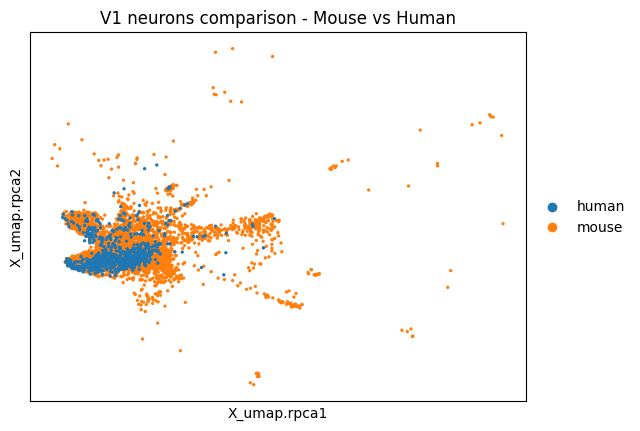

In [70]:
# Plot embeddings
sc.pl.embedding(comparison, basis = 'X_umap.rpca', color='species', save='_comparison_species.svg', title='V1 neurons comparison - Mouse vs Human')